In [ ]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import datetime as dt
from pivottablejs import pivot_ui
from IPython.display import HTML
import seaborn as sns
#import qgrid
#import ipywidgets as widgets

In [ ]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [ ]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

In [ ]:
prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [ ]:
stock_fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")

In [ ]:
print(stock_fundamentals.set_index(stock_fundamentals.iloc[:, 0]).index)

In [ ]:
#stock_fundamentals[stock_fundamentals.set_index(stock_fundamentals.iloc[:, 0]).index=='VOX']


In [ ]:
#prices[prices['Symbol']=='VOX'].set_index('Date')

In [ ]:
#plt.plot(prices[prices['Symbol']=='VOX'].set_index('Date')['Adj Close'])

In [ ]:
screener = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Screener")

In [ ]:
#screener.set_index('Symbol').loc['BA']

In [ ]:
fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")
fundamentals.set_index(fundamentals.columns[0],inplace=True)


In [ ]:
stock_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500")
stock_indexes.drop(stock_indexes.columns[0], axis=1, inplace=True)
stock_indexes.set_index(stock_indexes.columns[0],inplace=True)
stock_indexes

In [ ]:
spdr_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="spdr_indexes")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
spdr_indexes.set_index(spdr_indexes.columns[0],inplace=True)
spdr_indexes.columns=['Symbol']
spdr_indexes

In [ ]:
vanguard_sectors = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="vanguard_sectors")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
vanguard_sectors.set_index(vanguard_sectors.columns[0],inplace=True)
vanguard_sectors.columns=['Symbol']
vanguard_sectors

In [ ]:
#[*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]

In [ ]:
sector_performance_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_.index = subset_.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    tail = subset[subset.set_index('Date').index>=dt_str]
    dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)

In [ ]:
sector_performance_return

In [ ]:
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return = sector_performance_return.T

In [ ]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

sector_performance_return.style.background_gradient(cmap = cm,axis=1)

In [ ]:
sector_performance_return

In [ ]:
sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.columns:
    print(c)
    temp = pd.DataFrame(sector_performance_return[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(sector_performance_return[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))
sector_performances_values

In [ ]:
sector_performances = pd.DataFrame()
for c in sector_performance_return.columns:
    print(c)
    temp = pd.DataFrame(sector_performance_return[c].sort_values(ascending=False).index,columns=[c])
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))

In [ ]:
import matplotlib as mp
cycles_ = ['Expansion','Slowdown','Recession','Recovery']
from IPython.display import display
from PIL import Image

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

A = sector_performances_values
B = sector_performances
df = B.style.apply(b_g,cmap='RdYlGn')
#sector_performances.style.background_gradient(cmap = cm,axis=1,)
df


In [ ]:
sector_performance = []
for v in vanguard_sectors['Symbol']:
    sector_performance.append([v,screener[screener['Symbol']==v]['risk_trend_factor'].values[0]])
    #print([v,)
    

In [ ]:
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']

In [ ]:
pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)


In [ ]:
for v in sector_performance_return.index:
    subset = pd.DataFrame(sector_performance_return.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.index,loc=2)    
plt.show()


In [ ]:
sector_performance_return.T.iloc[-1].sort_values(ascending=False).index

In [ ]:
sector_performance_return

In [ ]:
sector_performance_return.T[sector_performance_return.T.iloc[-1].sort_values(ascending=False).index].style.background_gradient(cmap = cm,axis=None)

In [ ]:
#qgrid.show_grid(sector_dataset_pivot)

In [ ]:
threshold = .9875

In [ ]:
screener_good = screener[screener['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [ ]:
risk_trend_threshold

In [ ]:
stock_sectors = stock_fundamentals.set_index((stock_fundamentals.iloc[:, 0]))['sector']

In [ ]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']

In [ ]:
risk_screened = screener_good[screener_good['risk_trend_factor']>risk_trend_threshold]
risk_screened
#left join sector
risk_screened.merge(temp, on='Symbol', how='left')

In [ ]:
screener.columns

In [ ]:
"""
above_1yearSDev = screener_good[screener_good['latest_p']>screener['mean_1y']+screener_good['std_1y']]['Symbol'].values
above_2yearSDev = screener_good[screener_good['latest_p']>screener['mean_2y']+screener_good['std_2y']]['Symbol'].values
above_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)
"""

In [ ]:
#above_yearSDev

In [ ]:
"""
above_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values
above_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values
above_years_t = np.intersect1d(above_2year_t,above_1year_t)
"""

In [ ]:
#above_years_t

In [ ]:
#above_combined = np.intersect1d(above_yearSDev,above_years_t)

In [ ]:
#above_combined

In [ ]:
#screened_final_set = np.intersect1d(risk_screened,above_combined)

In [ ]:
screened_final_set = risk_screened.set_index('Symbol')
#screened_final_set

In [ ]:
pd.DataFrame(screener.set_index(screener.iloc[:,0]).loc[s]).dropna().T

In [ ]:
#v_ = np.setdiff1d(np.setdiff1d(screened_final_set.index,temp_v['Symbol'].values),spdr_indexes.iloc[:,0].values)[0]
#stock_fundamentals.drop(stock_fundamentals.index[stock_fundamentals[''] == 0], inplace = True)


In [ ]:
#pivot_ui(prices, outfile_path='pivottablejs.html')
#HTML('pivottablejs.html')

In [ ]:
subset.columns

In [ ]:
import pickle
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [ ]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [ ]:
loc

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
ACC


'ACC'

[['quarterly_balance_sheet',
                               2022-03-31    2021-12-31    2021-09-30  \
  Capital Surplus            4.693018e+09  4.694242e+09  4.538210e+09   
  Total Liab                 4.218002e+09  4.273301e+09  4.501487e+09   
  Total Stockholder Equity   3.093994e+09  3.117378e+09  2.982993e+09   
  Minority Interest          1.842520e+08  1.839070e+08  6.423900e+07   
  Deferred Long Term Liab    7.300000e+06  3.450000e+07  2.750000e+07   
  Total Assets               7.496248e+09  7.574586e+09  7.548719e+09   
  Common Stock               1.393000e+06  1.391000e+06  1.390000e+06   
  Other Current Assets       1.698800e+07  1.432600e+07  2.016300e+07   
  Other Liab                 1.522020e+08  1.697290e+08  1.850330e+08   
  Treasury Stock            -1.600417e+09 -1.578255e+09 -1.556607e+09   
  Other Assets               2.143290e+08  1.773490e+08  2.318220e+08   
  Cash                       8.765600e+07  1.203510e+08  4.207300e+07   
  Total Current Liabil

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
ACC,2.74796,64.730003,26040186.597938,0.985652,0.964437,0.248556


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
ACC,ACC,1.00147,2.184,122.276,1.88,0.029,1.498,466354240,0.47421,99.64615,...,0.176,7.081,Real Estate,0.86,NaN,87656000,0.63,4008523008,983433024,518.16


supply trend: 26040186.59793814
Index: SP400


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


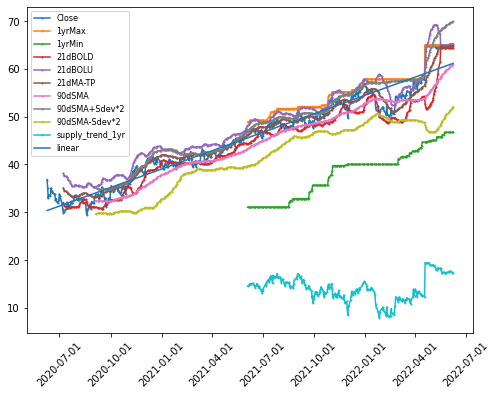

APA


'APA'

[['quarterly_balance_sheet',
                                      2021-12-31    2021-09-30    2021-06-30  \
  Capital Surplus                   1.164500e+10  1.168600e+10  1.170400e+10   
  Total Liab                        1.330800e+10  1.270500e+10  1.281900e+10   
  Total Stockholder Equity         -1.595000e+09 -1.095000e+09 -9.640000e+08   
  Minority Interest                 1.590000e+09  1.580000e+09  1.657000e+09   
  Deferred Long Term Liab           5.700000e+08  5.150000e+08  5.120000e+08   
  Other Current Liab                3.370000e+08  2.760000e+08  2.990000e+08   
  Total Assets                      1.330300e+10  1.331000e+10  1.351200e+10   
  Common Stock                      2.620000e+08  2.620000e+08  2.620000e+08   
  Other Current Assets              1.550000e+08  1.020000e+08  7.600000e+07   
  Retained Earnings                -9.488000e+09 -9.870000e+09 -9.757000e+09   
  Other Liab                        3.744000e+09  3.673000e+09  2.626000e+09   
  Treasury 

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
APA,1.046028,51.169998,197541093.608247,0.982472,0.997556,0.411319


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,returnOnEquity,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue
APA,APA,4.42549,1.124,NaN,0.5,0.0122,38.999,4470000128,0.55701,NaN,...,27.07216,0.905,21.457,Energy,1.45,NaN,302000000,0.871,7760999936,8024999936


supply trend: 197541093.6082474
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


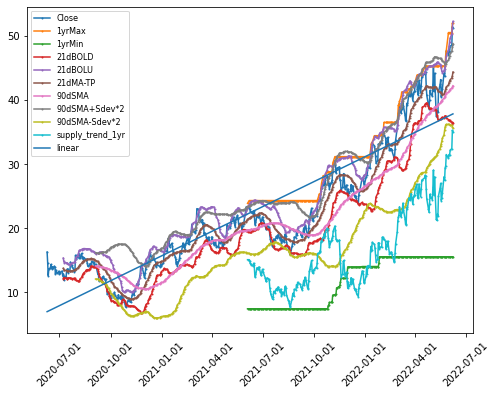

COP


'COP'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-08-19', '2023-01-20', '2024-01-19')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                           9.71
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo                              

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
COP,0.820306,121.860001,190916954.226804,0.977007,0.998092,0.385752


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
COP,COP,1.350272,1.513,38.088,1.92,0.0156,4.853,25497999360,0.46444,10.605744,...,0.828,41.447,Energy,1.83,NaN,7144000000,5.523,18745999360,54899998720,12.631906


supply trend: 190916954.2268041
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


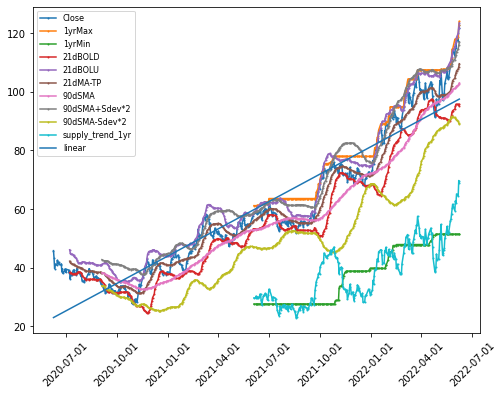

CTRA


'CTRA'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-07-15', '2022-09-16', '2023-01-20', '2024-01-19')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                          14.01
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo                

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
CTRA,1.216696,35.779999,167604738.14433,0.965424,0.999084,0.432234


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
CTRA,CTRA,-0.234119,1.565,29.266,0.6,0.0167,1.387,3284000000,0.63105,9.618279,...,3.243,8.591,Energy,3.43,NaN,1447000064,1.796,3444000000,5203999744,13.311011


supply trend: 167604738.1443299
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


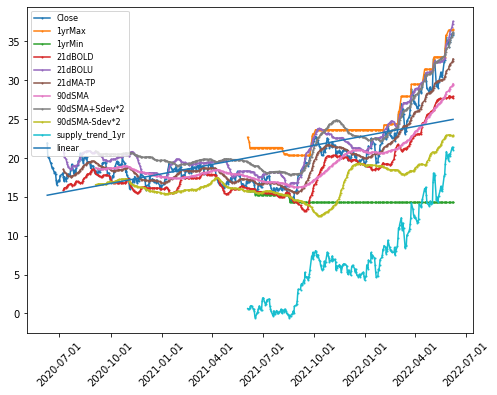

CVX


'CVX'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-06-17', '2023-01-20', '2024-01-19')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                          10.63
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo                              

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
CVX,0.924514,181.130005,239020305.360825,0.989168,0.997066,0.503962


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
CVX,CVX,1.078947,1.433,19.941,5.68,0.0315,3.473,38521999360,0.21783,12.431709,...,0.683,92.025,Energy,2.03,NaN,11704000512,5.957,29333000192,176843997184,17.0187


supply trend: 239020305.3608247
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


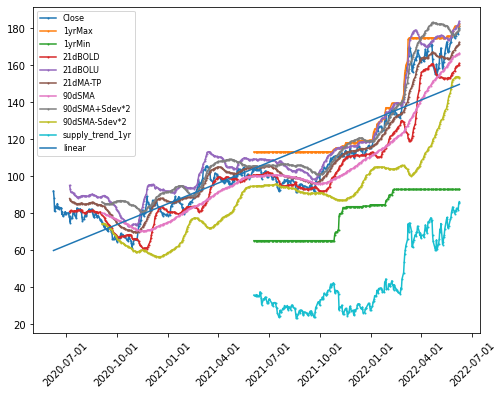

DVN


'DVN'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-07-15', '2023-01-20', '2024-01-19')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                           8.78
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo                              

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
DVN,0.980624,77.93,238032506.391753,0.982368,0.998988,0.381544


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
DVN,DVN,2.588475,1.325,71.489,5.08,0.0652,3.625,6653000192,0.4454,8.886986,...,0.74,22.47,Energy,1.45,NaN,2459000064,3.726,6744999936,14936999936,14.614228


supply trend: 238032506.3917526
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


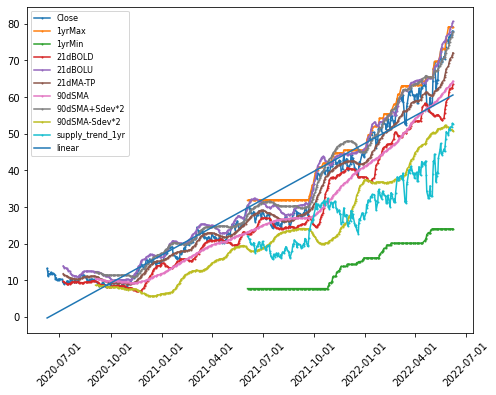

EQT


'EQT'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-06-17', '2023-01-20', '2024-01-19')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                          10.21
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo                              

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
EQT,1.283262,48.970001,137858884.329897,0.963901,0.998306,0.468927


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,returnOnEquity,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue
EQT,EQT,0.947822,0.398,61.543,0.5,0.0104,NaN,-1089323008,-0.13465,7.936791,...,-0.3018,1.206,23.313,Energy,2.08,NaN,16913000,0.046,5050277888,8089885184


supply trend: 137858884.3298969
Index: SP400


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


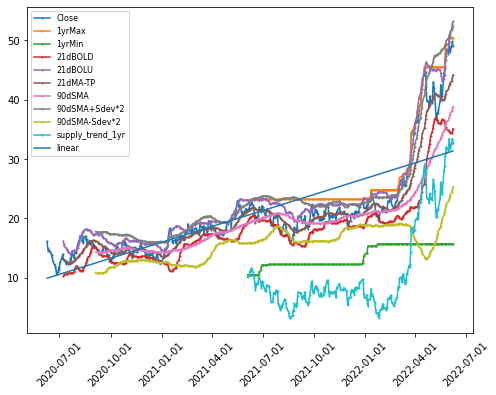

LNTH


'LNTH'

[['quarterly_balance_sheet',
                                     2022-03-31   2021-12-31   2021-09-30  \
  Intangible Assets                 340204000.0  348510000.0  356883000.0   
  Capital Surplus                   691516000.0  685472000.0  680819000.0   
  Total Liab                        417316000.0  399345000.0  348472000.0   
  Total Stockholder Equity          515850000.0  464439000.0  499344000.0   
  Other Current Liab                 89178000.0          NaN          NaN   
  Total Assets                      933166000.0  863784000.0  847816000.0   
  Common Stock                         686000.0     677000.0     677000.0   
  Other Current Assets               12860000.0    2705000.0   12043000.0   
  Retained Earnings                -178263000.0 -221225000.0 -181010000.0   
  Other Liab                         64083000.0  129181000.0   88437000.0   
  Good Will                          61189000.0   61189000.0   61189000.0   
  Treasury Stock                      1911000.0

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
LNTH,1.716236,72.089996,13932232.371134,0.973285,0.998931,0.528641


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,returnOnEquity,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue
LNTH,LNTH,0.943627,1.828,36.846,NaN,NaN,3.692,108329000,0.20002,75.42696,...,-0.07151,1.258,7.998,Healthcare,1.93,NaN,105355000,1.535,190072992,541579008


supply trend: 13932232.37113402
Index: SP600


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


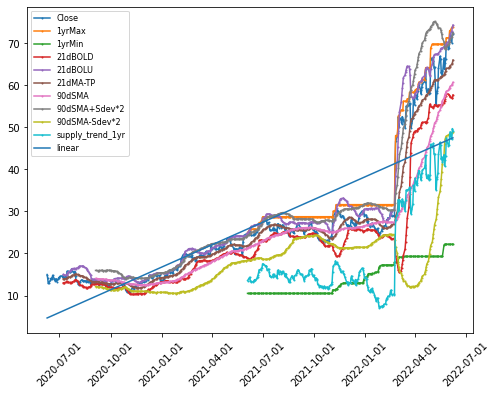

MCK


,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
MCK,1.033937,315.019989,22551770.103093,0.875512,0.985062,0.491201


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
MCK,MCK,0.663839,0.954,NaN,1.88,0.0059,-0.406,3191000064,0.01209,12.411926,...,0.118,1733.198,Healthcare,2.18,NaN,3532000000,24.297,7616999936,263965999104,43.771442


supply trend: 22551770.10309278
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


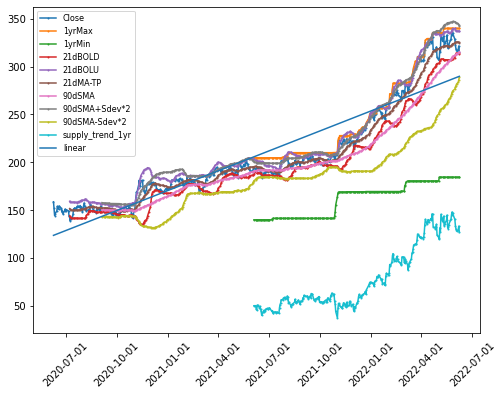

MPC


'MPC'

[['quarterly_balance_sheet',
                                      2021-12-31    2021-09-30    2021-06-30  \
  Capital Surplus                   3.326200e+10  3.325600e+10  3.323800e+10   
  Total Liab                        5.179200e+10  5.333600e+10  5.760700e+10   
  Total Stockholder Equity          2.620600e+10  2.828000e+10  2.892100e+10   
  Minority Interest                 7.375000e+09  7.684000e+09  7.772000e+09   
  Other Current Liab                2.278000e+09  3.377000e+09  6.148000e+09   
  Total Assets                      8.537300e+10  8.930000e+10  9.430000e+10   
  Common Stock                      1.000000e+07  1.000000e+07  1.000000e+07   
  Other Current Assets              5.680000e+08  5.850000e+08  5.850000e+08   
  Retained Earnings                 1.290500e+10  1.248400e+10  1.216000e+10   
  Other Liab                        7.999000e+09  8.193000e+09  8.825000e+09   
  Good Will                         8.256000e+09  8.256000e+09  8.256000e+09   
  Treasury 

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
MPC,0.938895,112.870003,139273334.845361,0.983142,0.999044,0.43444


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
MPC,MPC,1.910294,1.704,80.117,2.32,0.0242,1.917,7120999936,0.05912,26.388626,...,0.967,189.986,Energy,2.92,NaN,10839000064,19.177,26904000512,120450998272,7.816931


supply trend: 139273334.8453608
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


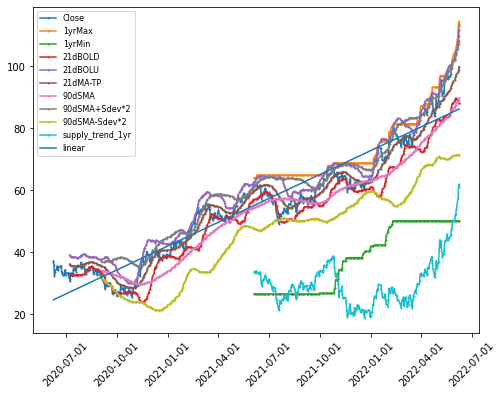

MRO


'MRO'

[['quarterly_balance_sheet',
                               2021-12-31    2021-09-30    2021-06-30  \
  Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
  Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
  Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
  Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
  Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
  Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
  Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
  Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
  Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
  Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
  Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
  Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
  Total Current Liabil

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
MRO,0.933455,31.93,475361004.948454,0.955608,0.998893,0.434829


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,returnOnEquity,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue
MRO,MRO,2.766666,1.112,38.48,0.32,0.0119,NaN,3308999936,0.58921,15.943877,...,0.08905,1.091,7.136,Energy,0.93,NaN,580000000,0.794,4112000000,5616000000


supply trend: 475361004.9484536
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


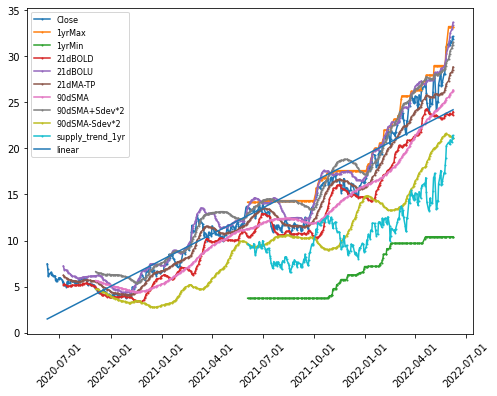

MTOR


,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
MTOR,1.652223,36.119999,15273304.742268,0.990077,0.524241,0.400653


,Unnamed: 0
MTOR,MTOR


supply trend: 15273304.74226804
Index: SP600


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


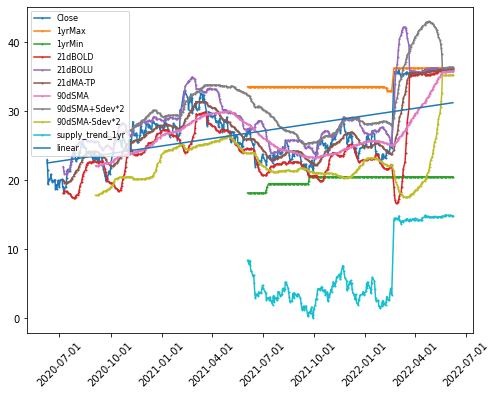

SJI


'SJI'

[['quarterly_balance_sheet',
                               2021-12-31    2021-09-30    2021-06-30  \
  Intangible Assets          1.404300e+07  1.473100e+07  1.611800e+07   
  Capital Surplus            1.559060e+09  1.463655e+09  1.462322e+09   
  Total Liab                 5.309231e+09  5.187967e+09  4.938285e+09   
  Total Stockholder Equity   1.989152e+09  1.828587e+09  1.887399e+09   
  Minority Interest          1.028900e+07  7.457000e+06  7.425000e+06   
  Deferred Long Term Liab    6.724160e+08  6.694870e+08  6.701760e+08   
  Other Current Liab         1.596050e+08  2.273930e+08  1.760970e+08   
  Total Assets               7.308672e+09  7.024011e+09  6.833109e+09   
  Common Stock               1.466750e+08  1.405610e+08  1.405570e+08   
  Other Current Assets       9.504100e+07  1.416900e+08  8.351100e+07   
  Retained Earnings          3.104330e+08  2.628420e+08  3.229880e+08   
  Other Liab                 1.141049e+09  1.165851e+09  1.163466e+09   
  Good Will           

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
SJI,0.772481,34.66,27428508.247423,0.961358,0.821762,0.398169


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
SJI,SJI,0.767156,0.669,180.745,1.24,0.0371,NaN,563539008,0.2829,20.479042,...,NaN,18.23,Utilities,3.26,NaN,28754000,0.245,3613896960,1991996032,48.78745


supply trend: 27428508.24742268
Index: SP600


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


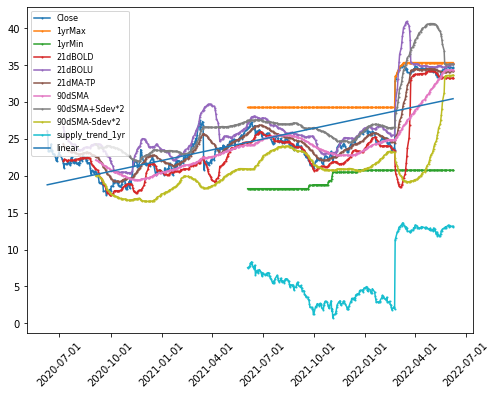

TVTY


'TVTY'

[['quarterly_balance_sheet',
                                     2021-12-31   2021-09-30   2021-06-30  \
  Intangible Assets                  29049000.0   29049000.0   29049000.0   
  Capital Surplus                   514461000.0  514313000.0  512674000.0   
  Total Liab                        479634000.0  490770000.0  488961000.0   
  Total Stockholder Equity          118907000.0  140669000.0   34787000.0   
  Other Current Liab                 22671000.0    3686000.0    3937000.0   
  Total Assets                      598541000.0  631439000.0  523748000.0   
  Common Stock                          50000.0      49000.0      49000.0   
  Other Current Assets               13733000.0   15610000.0   16423000.0   
  Retained Earnings                -359171000.0 -333825000.0 -436592000.0   
  Other Liab                          3202000.0     846000.0     976000.0   
  Good Will                         334680000.0  334680000.0  334680000.0   
  Treasury Stock                    -36433000.0

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
TVTY,1.584759,32.169998,10500521.443299,0.968282,0.645187,0.398114


,Unnamed: 0
TVTY,TVTY


supply trend: 10500521.44329897
Index: SP600


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


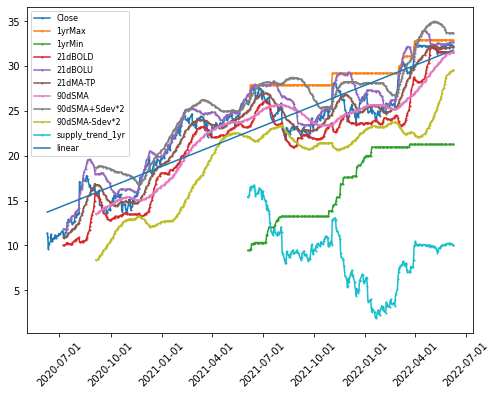

WMB


'WMB'

[['quarterly_balance_sheet',
                               2021-12-31    2021-09-30    2021-06-30  \
  Intangible Assets          7.402000e+09  7.481000e+09  7.277000e+09   
  Capital Surplus            2.444900e+10  2.442500e+10  2.440100e+10   
  Total Liab                 3.351100e+10  3.206600e+10  3.124200e+10   
  Total Stockholder Equity   1.138800e+10  1.116300e+10  1.147700e+10   
  Minority Interest          2.678000e+09  2.721000e+09  2.753000e+09   
  Other Current Liab         3.750000e+08  2.600000e+07  2.600000e+07   
  Total Assets               4.761200e+10  4.598500e+10  4.550700e+10   
  Common Stock               1.250000e+09  1.249000e+09  1.249000e+09   
  Other Current Assets       4.900000e+08  3.170000e+08  2.310000e+08   
  Retained Earnings         -1.323700e+10 -1.336100e+10 -1.302200e+10   
  Other Liab                 6.748000e+09  6.788000e+09  6.392000e+09   
  Treasury Stock            -1.074000e+09 -1.150000e+09 -1.151000e+09   
  Other Assets        

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
WMB,0.928194,37.490002,179022337.319588,0.975916,0.981545,0.353409


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
WMB,WMB,1.303921,0.915,169.059,1.7,0.0489,4.666,4482999808,0.41605,27.804688,...,0.416,8.867,Energy,2.32,NaN,1680000000,1.382,23839000576,10775000064,43.40244


supply trend: 179022337.3195876
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


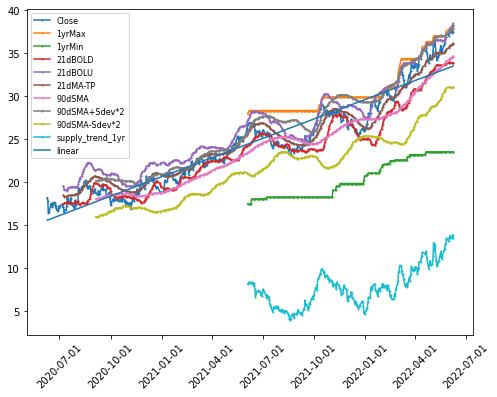

WRB


'WRB'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options', ('2022-07-15',)],
 ['sustainability',
                             Value
  2022-5                          
  palmOil                    False
  controversialWeapons       False
  gambling                   False
  socialScore                 7.83
  nuclear                    False
  furLeather                 False
  alcoholic                  False
  gmo                        False
  catholic                   False
  socialPercentile            None
  peerCount                     96
  governance

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
WRB,1.321099,71.019997,24485451.237113,0.963551,0.976404,0.420893


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
WRB,WRB,0.741517,0.453,44.413,0.35,0.0049,1.585,1969144064,0.19279,15.017057,...,0.352,36.85,Financial Services,1.22,NaN,3303750912,12.458,3059073024,10214005760,14.222536


supply trend: 24485451.2371134
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


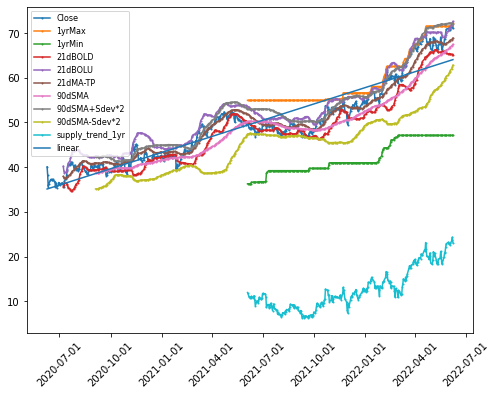

XOM


'XOM'

[['quarterly_balance_sheet',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_cashflow',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_earnings',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['quarterly_financials',
  Empty DataFrame
  Columns: [Open, High, Low, Close, Adj Close, Volume]
  Index: []],
 ['mutualfund_holders', None],
 ['options',
  ('2022-06-17', '2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')],
 ['sustainability',
                                       Value
  2022-5                                    
  palmOil                              False
  controversialWeapons                 False
  gambling                             False
  socialScore                           9.82
  nuclear                              False
  furLeather                           False
  alcoholic                            False
  gmo

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
XOM,1.055221,104.589996,552456789.896907,0.986839,0.997874,0.488125


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
XOM,XOM,1.040834,1.072,26.929,3.52,0.0341,1.003,53895000064,0.17427,11.818078,...,0.525,72.369,Energy,1.13,NaN,11073999872,2.629,47537000448,309269004288,17.34494


supply trend: 552456789.8969072
Index: SP500


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


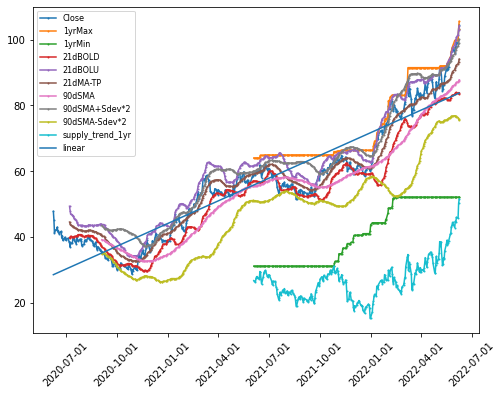

Y


'Y'

[['quarterly_balance_sheet',
                               2021-12-31    2021-09-30    2021-06-30  \
  Intangible Assets          1.511159e+09  1.465825e+09  1.453498e+09   
  Capital Surplus            3.608905e+09  3.611383e+09  3.612783e+09   
  Total Liab                 2.276445e+10  2.274715e+10  2.110891e+10   
  Total Stockholder Equity   9.186882e+09  8.859510e+09  9.142031e+09   
  Minority Interest          3.173460e+08  2.625260e+08  2.407220e+08   
  Other Current Liab         3.213810e+09  3.516756e+09  3.335249e+09   
  Total Assets               3.226868e+10  3.186919e+10  3.049166e+10   
  Common Stock               1.746000e+07  1.746000e+07  1.746000e+07   
  Other Current Assets       2.283585e+09  2.282419e+09  1.959696e+09   
  Retained Earnings          7.353226e+09  6.837060e+09  6.952026e+09   
  Other Liab                 1.156344e+10  1.634516e+10  1.541578e+10   
  Good Will                  7.536070e+08  6.318270e+08  6.276120e+08   
  Treasury Stock      

,volume_factor,latest_p,vol_30d_2yr,pct_2yr,adf,hurst
Y,1.634502,834.159973,1613947.42268,0.928634,0.752168,0.303435


,Unnamed: 0,beta,currentRatio,debtToEquity,dividendRate,dividendYield,earningsGrowth,ebitda,ebitdaMargins,forwardPE,...,revenueGrowth,revenuePerShare,sector,shortRatio,totalAssets,totalCash,totalCashPerShare,totalDebt,totalRevenue,trailingPE
Y,Y,0.70049,0.714,32.782,NaN,NaN,2.347,1693042048,0.14104,11.922999,...,0.335,866.486,Financial Services,2.14,NaN,2070224000,153.015,3115698944,12004105216,17.192856


supply trend: 1613947.422680412
Index: SP400


C:\Users\User\AppData\Local\Temp\ipykernel_14824\3532675363.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


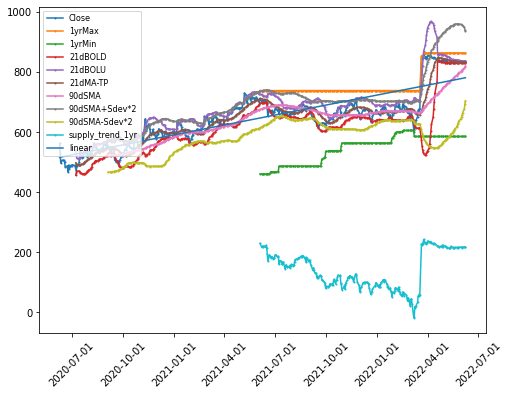

In [387]:
#from matplotlib.pyplot import figure

#figure(figsize=(8, 8), dpi=80)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")

for s in np.setdiff1d(np.setdiff1d(screened_final_set.index,temp_v['Symbol'].values),spdr_indexes.iloc[:,0].values):
    print(s)
    subset=prices[prices['Symbol']==s]
    
    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0]
        for items in fundamentals_quarterlies[loc[0]]:
            display(items)
    
    dates = []
    for t in subset['Date'].values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    display(pd.DataFrame(screener.set_index(screener.iloc[:,0]).loc[s]).dropna().T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])
    #display(pd.DataFrame(stock_fundamentals.set_index(stock_fundamentals.iloc[:,0]).loc[s]).dropna().T)
    temp = pd.DataFrame(stock_fundamentals.set_index(stock_fundamentals.iloc[:,0]).loc[s])
    display(temp[np.array(temp!='error')].T)
    
    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal
    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    fig, ax = plt.subplots()
    
    msize = 2
    plt.plot(x, y,marker = '.',markersize=msize)
    plt.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize)
    plt.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize)
    
    plt.plot(x, subset['21dBOLD'],marker = '.',markersize=msize)
    plt.plot(x, subset['21dBOLU'],marker = '.',markersize=msize)
    plt.plot(x, subset['21dMA-TP'],marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA'],marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA']+subset['90dSDev']*2,marker = '.',markersize=msize)
    plt.plot(x, subset['90dSMA']-subset['90dSDev']*2,marker = '.',markersize=msize)
    
    plt.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize)
    print("supply trend:",screener.loc[np.where(screener.set_index('Symbol').index==s)[0][0]]['vol_30d_2yr'])
    print("Index:", stock_indexes.iloc[np.where(np.array(stock_indexes.index)==s)[0][0]][0])
    plt.plot(x, mymodel)
    
    labels = ['Close','1yrMax','1yrMin','21dBOLD','21dBOLU','21dMA-TP','90dSMA','90dSMA+Sdev*2','90dSMA-Sdev*2','supply_trend_1yr','linear']
    
    plt.legend(labels, fontsize=8,loc=2)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.show()